In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
from datetime import datetime
from datetime import date

In [2]:
#DEAR -> REPORTS -> SALES BY PRODUCT DETAILS -> [select time frame] -> EXPORT -> EXCEL WITHOUT TOTALS

#df = pd.read_excel('last6modetails.xlsx',engine='openpyxl',header=0,skiprows=5, parse_dates=False)#parse_dates didn't work, see below
df = pd.read_excel('last6mowine2.xlsx',engine='openpyxl',header=0,skiprows=5)

#print(df.iloc[38:45])#head is full of junk right now lol - cleaning time!

In [3]:
#initial cleaning setup
list_of_retail_stores = ['Customer Square ' + str(x) for x in range(1,4)] #we have 3 stores active, we won't count the Warehouse
retail_names = ['Airport','Pleasant Valley','Oak Hill'] # make sure this matches the above list length - no known automation possible
store_map = dict(zip(list_of_retail_stores,retail_names))

#ws = df[df.Customer.isin(list_of_retail_stores) == False]
df = df[df.Customer.isin(list_of_retail_stores) & df.Product.notnull()].reset_index(drop=True) #remove wholesale and weird null anomoly entries

df['Customer'] = df.apply(lambda row: store_map[row.Customer], axis =1)

In [4]:
#df['SKU'] = df.SKU.apply(str)
temp = df.groupby(["Product","Customer"]).Quantity.sum().reset_index()
temp#[temp['Product'].duplicated()]

,Product,Customer,Quantity
0,1 Water 355ml,Airport,1
1,123 Organic Anejo Tequila 750ml,Pleasant Valley,1
2,123 Organic Blanco Tequila 750ml,Airport,2
3,123 Organic Blanco Tequila 750ml,Pleasant Valley,8
4,123 Organic Reposado Tequila 750ml,Airport,1
...,...,...,...
8024,Zucca Rabarbaro 750ml,Oak Hill,3
8025,Zucca Rabarbaro 750ml,Pleasant Valley,3
8026,Zwack Liqueur 750ml,Airport,8
8027,Zwack Liqueur 750ml,Pleasant Valley,3


In [6]:
#start cleaning some of the unused or needed columns / rows, converting "Invoice Date" to datetime objects
df = df.drop(['SKU', 'COGS','Profit'], axis=1, inplace=False) #UNIT???? not trusted data columns or useful, we'll ignore them for now
df = df.rename(columns={'Invoice Date':'Date'})#renaming for legibility 

In [7]:
#df['Date'] = pd.to_datetime(df['Date'], format='%d-%b-%Y')#get these dates converted from string to something more powerful
#df['Month'] = df.Date.apply(lambda x: x.month)#.month_name() also an option but i dont trust yet
#df['Weekday'] = df.Date.apply(lambda x: x.dayofweek)#Monday is 0, Sunday is 6, day_name() also an option but i dont trust yet
#df['Week'] = df.Date.apply(lambda x: x.isocalendar()[1])#x.isocalendar().week
#df["Unit"] = df.Sale / df.Quantity
df.head()

,Product,Category,Date,Customer,Quantity,Sale
0,Matthiasson Cabernet Sauvignon 750ml,Red New World,04-Dec-2021,Pleasant Valley,1,67.99
1,Matthiasson Cabernet Sauvignon 750ml,Red New World,11-Dec-2021,Pleasant Valley,1,67.99
2,Matthiasson Cabernet Sauvignon 750ml,Red New World,11-Dec-2021,Oak Hill,1,67.99
3,Matthiasson Cabernet Sauvignon 750ml,Red New World,17-Dec-2021,Oak Hill,1,67.99
4,Matthiasson Cabernet Sauvignon 750ml,Red New World,14-Jan-2022,Pleasant Valley,1,67.99


In [8]:
#quick wine filter setup and check to make sure there's no items with bad categories that need fixing

wine_list = ['White','Orange Wine','Bubbles','Red New World','Red Old World','Rose']#active categories just for vino


## Read in Pars


In [9]:
read_pars = pd.read_csv('StockReorderlocations_2022-02-18.csv',header=0,dtype=str)#parse_dates
read_pars.rename(columns={'ProductName':'Product','Location':'Customer'},inplace=True)
read_pars.drop(['StockLocator','PickZones'],inplace=True,axis=1)
read_pars.MinimumBeforeReorder = read_pars.MinimumBeforeReorder.astype(float)
read_pars.MinimumBeforeReorder = read_pars.MinimumBeforeReorder.astype(int)
read_pars.ReorderQuantity = read_pars.ReorderQuantity.astype(float)
read_pars.ReorderQuantity = read_pars.ReorderQuantity.astype(int)
read_pars.head()

,Action,ProductSKU,Product,Customer,MinimumBeforeReorder,ReorderQuantity
0,Create/Update,086785024684,Drumshanbo Irish Gin 375ml,Oak Hill,1,12
1,Create/Update,086785024684,Drumshanbo Irish Gin 375ml,Pleasant Valley,4,12
2,Create/Update,086785024684,Drumshanbo Irish Gin 375ml,Airport,1,12
3,Create/Update,786992000609,Chairmans Spiced Rum 750ml,Warehouse,4,6
4,Create/Update,786992000609,Chairmans Spiced Rum 750ml,Oak Hill,2,4


# here we go

In [11]:
full = df.merge(right=read_pars,on=['Product','Customer'], how='outer')
full['Unit'] = full.Sale / full.Quantity
full = full.drop(['Sale','Action','ProductSKU'],axis=1)#INVOICE
full.rename(columns={'Quantity':'SoldLast6m'},inplace=True)
wine = full[full.Category.isin(wine_list)].sort_values('Product')
wine.to_csv('winefull6mo.csv',index=False)

In [13]:
#top sellers
wine_pivot = df[df['Category'].isin(wine_list)].pivot_table(columns=['Customer'],index='Product',values='Quantity',aggfunc='sum')

wine_pivot.rename(columns=store_map,inplace=True)
wine_pivot.fillna(0,inplace=True)
wine_pivot['Total'] = wine_pivot.iloc[1:].sum(axis=1)
wine_pivot.sort_values('Total',ascending=False).head(15)

#wine_pivot = wine_pivot.merge(right=read_pars,on=['Product','Customer'], how='inner') lmfao

wine_pivot.to_csv('blah.csv')

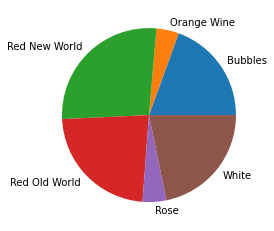

In [15]:
linegraph = df[df["Product"].str.contains(" 50m")==False] #remove minis
linegraph = linegraph.groupby(['Category']).Quantity.sum().reset_index()#example, (pd.Grouper(key='Date', freq='1M')) gave some weird results 

piechart = linegraph[linegraph.Category.isin(wine_list)].groupby('Category').Quantity.sum().reset_index()
#print(piechart)
plt.pie(piechart.Quantity,labels=piechart.Category)
plt.show()